In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
#import pymc3 as pm
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import rpy2
from rpy2.robjects import pandas2ri

pandas2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme <- theme_light() + theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

paper_theme_2 <- theme_light() + theme(
                                       legend.text=element_text(size=14), 
                            legend.title=element_blank(),
                     legend.key = element_rect(color = "transparent", fill="transparent"),
                            legend.position=c(0.82,0.82),
                            strip.text=element_blank(), 

                            axis.text.x=element_text(size=16,color="black"),
                            axis.text.y=element_text(size=16,color="black"),
                            axis.title.x=element_text(face="plain", size=20),
                            axis.title.y=element_text(face="plain", size=20)) 


/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145:

In [3]:
data = pd.read_csv("mc_data_big.csv")
subj_group = data.groupby(["subj","incr","n_query", "stim"])


subj_data = {}
for i, trial in subj_group:
    subj = list(trial["subj"])[0]
    if subj not in subj_data:
        subj_data[subj] = []
        
    cnt = [x.count(".") for x in list(trial["stim"])]
    

    tup = (list(trial["guess"])[0],
               list(trial["mod_pred"]), list(trial["cplx"]),
           list(trial["dist"]), cnt, list(trial["concept"]))
    subj_data[subj].append(tup)

    




In [4]:
keys = list(subj_data.keys())
subjs = []
hum_preds = []
mod_preds = []
cplxs = []
dists = []
seen = []
mdls=[]
concs=[]
for key in keys:
    tups = subj_data[key]
    m1,m2,m3,m4,m5,m6,m7= [],[],[],[],[],[],[]

    if len(tups) == 160:
        for tup in tups:
            m1.append(key)
            m2.append(tup[0])
            m3.append(tup[1])
            m4.append(tup[2])
            m5.append(tup[3])
            m6.append(tup[4])
            m7.append(tup[5])
        subjs.append(m1)
        hum_preds.append(m2)
        mod_preds.append(m3)
        cplxs.append(m4)
        dists.append(m5)
        seen.append(m6)
        concs.append(m7)
        
        
        
        mdl_s =[]
        for i in range(15,len(m6),16):
            
            poss = []

            for j in range(len(m4[i])):
                if m5[i][j] == 0:
                    conc = m7[i][j][2:]
                    if (not ("0" in conc)) or (not ("1" in conc)):
                        poss.append(0)
                    else:
                        poss.append(m4[i][j])
                    
            if len(poss) == 0:
                mdl = 16
            else:
                mdl = min(poss)
            mdl_s.append(mdl)            
            
        mdls.append(np.mean(mdl_s[:5]))
            

subjs = np.array(subjs)
hum_preds = np.array(hum_preds)
mod_preds = np.array(mod_preds)
cplxs = np.array(cplxs)
dists = np.array(dists)
seen = 16 - np.array(seen)
mdls=np.array(mdls)
mdls_std = (mdls-np.mean(mdls))/np.std(mdls)

mod_shape = cplxs.shape
hum_shape = hum_preds.shape

In [5]:
def compute_posterior(complexities,predictions,hum_data,dists,seen, alpha,beta,noise):
    theta = 1./beta
    


    probs = st.gamma.pdf(complexities,a=alpha,scale=theta)
    #print(probs)


    probs = probs * noise**dists
    probs = probs * ((1-noise)**(seen-dists))

    norm = np.sum(probs, axis=2,keepdims=True)
    
    probs = probs/norm
    probs = probs * predictions
    
    probs = np.sum(probs,axis=2)
    probs = probs + (0.5-probs)*noise
    posterior = st.bernoulli.logpmf(hum_data, probs)

    #print(prior)
    
    
    return(np.sum(posterior))


def compute_posterior_multiple(complexities,predictions,hum_data,dists,seen, alpha,beta,noise,loc):
    theta = 1./beta
    
    noise_orig = copy.deepcopy(noise).reshape((len(predictions),1))
    

    alpha = alpha.reshape((len(predictions),1,1))
    theta = theta.reshape((len(predictions),1,1))
    noise = noise.reshape((len(predictions),1,1))
    loc = loc.reshape((len(predictions),1,1))

    probs = st.gamma.pdf(complexities,a=alpha,loc=loc,scale=theta)
   # print(probs)
    #print("*"*30)

    probs = probs * noise**dists
    probs = probs * ((1-noise)**(seen-dists))

    norm = np.sum(probs, axis=2,keepdims=True)
    
   # print (probs/norm)
    probs = probs/norm
    probs = probs * predictions
    
    probs = np.sum(probs,axis=2)
    probs = probs + (0.5-probs)*noise_orig
    posterior = st.bernoulli.logpmf(hum_data, probs)

    #print(prior)
    
    
    return(np.sum(posterior))
    
    
a1 = np.ones(3)*0.5
b1 = np.ones(3)*1
n1 = np.ones(3)*0.2
l1 = np.zeros(3)
pr2 = compute_posterior_multiple(cplxs[:3], mod_preds[:3],hum_preds[:3],dists[:3],seen[:3],a1,b1,n1,l1)



In [84]:
####         

n_steps = 2500
n_chains = 3
burn_in = 7500
anti_spread = 10.
acceptance_temperature = 1

prop_stds, curr_stds = 1,1

all_alphas,all_betas,all_locs,all_noises,all_posts = [],[],[],[],[]




def prior_penalty(lst):
   # stds = 0.
    prob = 0.
    for l in lst:
       # stds +=  np.std(l)**2.
        prob += np.sum(st.norm.logpdf(l,l.mean(),2.))
        
    return prob#- anti_spread * stds


for chain in range(n_chains):

    alphas,betas,noises,posts,locs= [],[],[],[],[]


    curr_alpha = np.ones(len(mod_preds)) * 2. + np.random.random(len(mod_preds))
    curr_beta = np.ones(len(mod_preds)) * 1. + np.random.random(len(mod_preds))
    curr_loc = np.random.normal(0.0,0.01,len(mod_preds))
    curr_loc = np.zeros(len(mod_preds))

    curr_noise_logistic = np.random.normal(-1.25,0.1,len(mod_preds))+ np.random.normal(0,0.05,len(mod_preds))

    curr_noise = 1/(1+np.exp(-curr_noise_logistic))
    
    curr_posterior = compute_posterior_multiple(cplxs,mod_preds,hum_preds,dists,seen, curr_alpha,
                                                curr_beta,curr_noise,curr_loc)
    #curr_posterior +=  prior_penalty([curr_alpha,curr_beta,curr_loc,curr_noise]) 
   # curr_posterior += np.sum(st.expon.logpdf(curr_noise))
    
    
    add_alpha,add_beta,add_noise,add_mdl_alpha = 0,0,0,0
    accepted= False


    for step in range(n_steps + burn_in):
        if accepted == False:
            add_alpha = np.random.normal(np.random.normal(0,random.random()*0.05),random.random()*0.1,len(curr_alpha))
            add_beta = np.random.normal(np.random.normal(0,random.random()*0.05),random.random()*0.1,len(curr_beta))
            add_noise =np.random.normal(np.random.normal(-0.005,random.random()*0.05),random.random()*0.05,len(mod_preds))
            add_loc =np.random.normal(np.random.normal(0,random.random()*0.01),random.random()*0.05,len(curr_loc))


            

        else:
            add_alpha = np.random.normal(add_alpha,0.001,len(add_alpha))
            add_beta =  np.random.normal(add_beta,0.001,len(add_beta))
            add_noise =  np.random.normal(add_noise,0.001,len(add_noise))
            add_loc = np.random.normal(add_loc, 0.001, len(add_noise))

            
    
        
        prop_loc = curr_loc + add_loc
        #prop_loc = np.zeros(len(mod_preds))


        prop_alpha = np.abs(curr_alpha+add_alpha)
        prop_beta = np.abs(curr_beta + add_beta)

        prop_noise_logistic = curr_noise_logistic + add_noise
        prop_noise = 1/(1+np.exp(-prop_noise_logistic))
        
        
        
        prop_stds = 0.

        #prop_stds = prior_penalty([prop_alpha,prop_beta,prop_loc,prop_noise]) 
       # prop_stds += np.sum(st.expon.logpdf(prop_noise))
        

        prop_posterior = compute_posterior_multiple(cplxs,mod_preds,hum_preds,dists,seen, 
                                                    prop_alpha,prop_beta,prop_noise,prop_loc)
        prop_posterior = prop_posterior + prop_stds
        
        
      #  print(np.exp(prop_posterior - curr_posterior))

        if ((prop_posterior > curr_posterior) or 
            (np.exp(prop_posterior - curr_posterior) > random.random()/acceptance_temperature)):
            curr_posterior = prop_posterior
            curr_alpha = prop_alpha
            curr_beta = prop_beta
            curr_noise = prop_noise
            curr_noise_logistic=prop_noise_logistic
            curr_stds = prop_stds
            curr_loc = prop_loc


 
        if prop_posterior > curr_posterior:
            accepted=True
        else:
            accepted = False

        if (step % 10 == 0):
            if (step > burn_in):
                alphas.append(list(curr_alpha))
                betas.append(list(curr_beta))
                noises.append(list(curr_noise))
                posts.append(curr_posterior)
                locs.append(list(curr_loc))
                
                
                
            preds,pred_means=[],[]
                
            for i in range(len(curr_alpha)):
                xs = np.arange(0,17,1)
                pred = st.gamma.pdf(xs, a=curr_alpha[i], loc=curr_loc[i], scale=1./curr_beta[i])
                pred = pred/np.sum(pred)
                
                pred_mean = np.sum(pred*xs)
                pred_means.append(pred_mean)
                preds.append(list(pred))
                
                
            preds = np.array(preds)
        
                


            corr_means = st.pearsonr(pred_means, mdls_std)

            print(chain, step, round(curr_posterior-curr_stds),
                  round(curr_alpha.mean(),1),round(curr_beta.mean(),1),round(curr_noise.mean(),2),
                  round(curr_loc.mean(),1),round(curr_stds,1),round(np.mean(pred_means),1),
                  round(corr_means[0],2))
            
            
            preds = np.mean(preds,axis=0)
            print([round(x,2) for x in preds])
            print("")
            
            


    all_alphas.append(copy.deepcopy(alphas))
    all_betas.append(copy.deepcopy(betas))
    all_noises.append(copy.deepcopy(noises))
    all_posts.append(copy.deepcopy(posts))
    all_locs.append(copy.deepcopy(locs))

    
all_alphas = np.array(all_alphas)
all_betas = np.array(all_betas)
all_noises = np.array(all_noises)
all_posts = np.array(all_posts)
all_locs = np.array(all_locs)

print("DONE!")

0 0 -9464.0 2.5 1.5 0.22 0.0 1 1.9 -0.02
[0.0, 0.49, 0.3, 0.13, 0.05, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 10 -9447.0 2.5 1.5 0.21 0.0 0.0 1.8 0.01
[0.02, 0.49, 0.29, 0.12, 0.05, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 20 -9442.0 2.4 1.4 0.2 0.0 0.0 1.9 0.01
[0.03, 0.46, 0.28, 0.13, 0.05, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 30 -9436.0 2.3 1.4 0.2 0.0 0.0 1.8 0.0
[0.05, 0.46, 0.27, 0.13, 0.05, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 40 -9433.0 2.3 1.4 0.2 0.0 0.0 1.8 0.0
[0.05, 0.46, 0.27, 0.12, 0.05, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 50 -9418.0 2.4 1.4 0.19 0.0 0.0 1.9 0.05
[0.05, 0.44, 0.28, 0.13, 0.06, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 60 -9399.0 2.4 1.4 0.2 -0.0 0.0 1.9 0.07
[0.07, 0.43, 0.27, 0.12, 0.05, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 70 -9389.0 2.3 1.4 0.19 0.0 0.0 1.8 0.1
[0.07,

0 590 -9173.0 2.2 1.5 0.2 0.0 0.0 2.1 0.13
[0.17, 0.36, 0.21, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 600 -9172.0 2.2 1.4 0.2 0.0 0.0 2.1 0.14
[0.17, 0.35, 0.21, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 610 -9165.0 2.2 1.4 0.2 0.0 0.0 2.2 0.13
[0.16, 0.36, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 620 -9165.0 2.2 1.4 0.19 0.0 0.0 2.1 0.14
[0.17, 0.36, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 630 -9168.0 2.2 1.4 0.2 0.0 0.0 2.2 0.14
[0.16, 0.35, 0.22, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 640 -9161.0 2.2 1.4 0.19 0.0 0.0 2.2 0.13
[0.16, 0.35, 0.21, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 650 -9161.0 2.2 1.4 0.19 0.0 0.0 2.2 0.13
[0.16, 0.35, 0.21, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 660 -9161.0

0 1170 -9110.0 2.5 1.5 0.19 -0.0 0.0 2.5 0.19
[0.15, 0.33, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 1180 -9108.0 2.5 1.5 0.19 -0.0 0.0 2.5 0.18
[0.15, 0.34, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 1190 -9111.0 2.5 1.5 0.19 -0.0 0.0 2.5 0.19
[0.16, 0.33, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 1200 -9111.0 2.5 1.5 0.19 -0.0 0.0 2.5 0.19
[0.16, 0.33, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 1210 -9105.0 2.5 1.5 0.19 -0.0 0.0 2.6 0.2
[0.15, 0.32, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 1220 -9108.0 2.4 1.5 0.19 -0.0 0.0 2.5 0.19
[0.16, 0.33, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 1230 -9106.0 2.4 1.5 0.19 -0.0 0.0 2.4 0.16
[0.16, 0.33, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0

0 1730 -9053.0 2.6 1.6 0.2 -0.2 0.0 2.2 0.15
[0.19, 0.33, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 1740 -9052.0 2.6 1.5 0.2 -0.2 0.0 2.3 0.16
[0.19, 0.32, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

0 1750 -9052.0 2.6 1.6 0.2 -0.2 0.0 2.3 0.16
[0.19, 0.33, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

0 1760 -9048.0 2.6 1.5 0.21 -0.2 0.0 2.3 0.15
[0.18, 0.32, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 1770 -9048.0 2.6 1.5 0.21 -0.2 0.0 2.4 0.15
[0.17, 0.32, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

0 1780 -9048.0 2.7 1.6 0.2 -0.2 0.0 2.2 0.16
[0.18, 0.33, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 1790 -9048.0 2.6 1.6 0.2 -0.2 0.0 2.2 0.16
[0.19, 0.33, 0.21, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0

0 2300 -9052.0 2.7 1.8 0.2 -0.2 0.0 2.0 0.07
[0.2, 0.34, 0.22, 0.09, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 2310 -9053.0 2.7 1.8 0.2 -0.2 0.0 2.0 0.06
[0.2, 0.34, 0.22, 0.09, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 2320 -9053.0 2.7 1.8 0.2 -0.2 0.0 2.0 0.06
[0.2, 0.34, 0.22, 0.09, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 2330 -9048.0 2.7 1.7 0.2 -0.2 0.0 2.2 0.04
[0.2, 0.34, 0.21, 0.09, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

0 2340 -9047.0 2.7 1.7 0.2 -0.2 0.0 2.1 0.06
[0.2, 0.34, 0.21, 0.09, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 2350 -9047.0 2.7 1.8 0.2 -0.2 0.0 2.1 0.04
[0.2, 0.34, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 2360 -9047.0 2.7 1.8 0.2 -0.2 0.0 2.1 0.04
[0.2, 0.34, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 2870 -9020.0 3.0 1.7 0.2 -0.3 0.0 2.5 0.08
[0.17, 0.31, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 2880 -9024.0 3.0 1.7 0.2 -0.3 0.0 2.5 0.08
[0.17, 0.31, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 2890 -9012.0 3.0 1.8 0.21 -0.3 0.0 2.3 0.07
[0.18, 0.33, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

0 2900 -9012.0 3.0 1.8 0.21 -0.3 0.0 2.3 0.07
[0.18, 0.33, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

0 2910 -9012.0 3.0 1.8 0.21 -0.3 0.0 2.3 0.07
[0.18, 0.33, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

0 2920 -9015.0 3.0 1.8 0.21 -0.3 0.0 2.4 0.05
[0.18, 0.32, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 2930 -9015.0 3.0 1.8 0.21 -0.3 0.0 2.4 0.05
[0.18, 0.32, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.

0 3440 -9006.0 3.3 1.8 0.21 -0.3 0.0 2.2 0.07
[0.16, 0.32, 0.24, 0.11, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 3450 -9004.0 3.1 1.8 0.2 -0.3 0.0 2.2 0.08
[0.18, 0.33, 0.23, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 3460 -9007.0 3.1 1.8 0.2 -0.3 0.0 2.1 0.07
[0.18, 0.33, 0.23, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0 3470 -9007.0 3.1 1.8 0.2 -0.3 0.0 2.2 0.07
[0.18, 0.33, 0.23, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 3480 -9006.0 3.1 1.8 0.22 -0.3 0.0 2.3 0.07
[0.17, 0.32, 0.22, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 3490 -9002.0 3.2 1.8 0.21 -0.3 0.0 2.2 0.09
[0.18, 0.32, 0.23, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

0 3500 -9004.0 3.2 1.8 0.21 -0.3 0.0 2.3 0.09
[0.17, 0.31, 0.23, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.

0 4010 -8975.0 3.1 1.7 0.2 -0.3 0.0 2.4 0.24
[0.16, 0.29, 0.23, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 4020 -8971.0 3.1 1.7 0.21 -0.3 0.0 2.4 0.24
[0.16, 0.3, 0.23, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 4030 -8972.0 3.1 1.7 0.21 -0.3 0.0 2.4 0.24
[0.17, 0.3, 0.23, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 4040 -8976.0 3.1 1.7 0.21 -0.3 0.0 2.3 0.24
[0.17, 0.31, 0.23, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 4050 -8975.0 3.1 1.7 0.2 -0.3 0.0 2.5 0.24
[0.16, 0.3, 0.23, 0.11, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 4060 -8974.0 3.1 1.7 0.21 -0.3 0.0 2.4 0.25
[0.16, 0.31, 0.22, 0.11, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 4070 -8975.0 3.1 1.7 0.2 -0.3 0.0 2.4 0.24
[0.16, 0.3, 0.23, 0.11, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0

0 4570 -8986.0 3.0 1.6 0.2 -0.4 0.0 2.8 0.14
[0.17, 0.28, 0.21, 0.1, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 4580 -8985.0 3.0 1.6 0.2 -0.4 0.0 2.9 0.16
[0.17, 0.28, 0.21, 0.1, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 4590 -8983.0 3.0 1.7 0.2 -0.4 0.0 2.6 0.13
[0.19, 0.3, 0.21, 0.09, 0.05, 0.03, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 4600 -8983.0 3.0 1.7 0.2 -0.4 0.0 2.5 0.13
[0.19, 0.3, 0.21, 0.09, 0.05, 0.03, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 4610 -8982.0 3.0 1.6 0.2 -0.4 0.0 2.9 0.14
[0.18, 0.29, 0.21, 0.09, 0.05, 0.03, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 4620 -8979.0 3.0 1.6 0.2 -0.4 0.0 2.8 0.14
[0.19, 0.28, 0.21, 0.09, 0.05, 0.03, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 4630 -8979.0 2.9 1.6 0.2 -0.4 0.0 2.7 0.14
[0.2, 0.29, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 

0 5130 -8977.0 3.1 1.6 0.21 -0.5 0.0 2.6 0.17
[0.19, 0.29, 0.2, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 5140 -8978.0 3.1 1.6 0.21 -0.5 0.0 2.7 0.17
[0.19, 0.28, 0.2, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 5150 -8977.0 3.1 1.5 0.21 -0.5 0.0 2.8 0.16
[0.19, 0.28, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 5160 -8975.0 3.1 1.5 0.22 -0.5 0.0 2.8 0.15
[0.19, 0.28, 0.19, 0.1, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 5170 -8972.0 3.1 1.6 0.22 -0.5 0.0 2.5 0.13
[0.2, 0.29, 0.19, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 5180 -8968.0 3.0 1.6 0.21 -0.5 0.0 2.6 0.13
[0.2, 0.28, 0.2, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 5190 -8968.0 3.0 1.6 0.21 -0.5 0.0 2.6 0.13
[0.2, 0.28, 0.2, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0

0 5700 -8942.0 3.5 1.8 0.22 -0.6 0.0 2.2 0.13
[0.22, 0.29, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 5710 -8943.0 3.5 1.8 0.22 -0.6 0.0 2.3 0.14
[0.22, 0.29, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 5720 -8943.0 3.5 1.8 0.22 -0.6 0.0 2.3 0.14
[0.22, 0.29, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

0 5730 -8943.0 3.5 1.7 0.22 -0.6 0.0 2.3 0.14
[0.21, 0.29, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

0 5740 -8944.0 3.4 1.7 0.21 -0.6 0.0 2.4 0.14
[0.22, 0.29, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

0 5750 -8945.0 3.3 1.7 0.23 -0.6 0.0 2.3 0.13
[0.23, 0.29, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

0 5760 -8945.0 3.3 1.7 0.23 -0.6 0.0 2.3 0.14
[0.23, 0.29, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01

0 6260 -8942.0 3.5 1.7 0.21 -0.6 0.0 2.6 0.17
[0.21, 0.27, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 6270 -8942.0 3.6 1.7 0.21 -0.6 0.0 2.5 0.17
[0.21, 0.28, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 6280 -8944.0 3.6 1.7 0.21 -0.6 0.0 2.5 0.16
[0.21, 0.28, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 6290 -8946.0 3.5 1.8 0.21 -0.6 0.0 2.4 0.17
[0.22, 0.28, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

0 6300 -8948.0 3.5 1.8 0.23 -0.6 0.0 2.3 0.17
[0.22, 0.28, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

0 6310 -8948.0 3.5 1.7 0.23 -0.6 0.0 2.5 0.17
[0.21, 0.27, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0]

0 6320 -8948.0 3.5 1.7 0.22 -0.6 0.0 2.4 0.18
[0.22, 0.28, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 

0 6820 -8946.0 3.4 1.7 0.22 -0.6 0.0 2.5 0.18
[0.23, 0.27, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 6830 -8942.0 3.4 1.7 0.21 -0.6 0.0 2.5 0.19
[0.23, 0.27, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 6840 -8944.0 3.4 1.7 0.22 -0.6 0.0 2.5 0.19
[0.23, 0.27, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 6850 -8943.0 3.4 1.7 0.23 -0.6 0.0 2.4 0.18
[0.24, 0.27, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 6860 -8941.0 3.4 1.8 0.22 -0.6 0.0 2.3 0.18
[0.24, 0.28, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 6870 -8940.0 3.4 1.7 0.22 -0.6 0.0 2.4 0.18
[0.24, 0.27, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 6880 -8940.0 3.4 1.7 0.22 -0.6 0.0 2.4 0.18
[0.24, 0.27, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0

0 7380 -8935.0 3.9 1.8 0.21 -0.7 0.0 2.7 0.2
[0.2, 0.26, 0.22, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7390 -8938.0 3.8 1.8 0.2 -0.7 0.0 2.6 0.18
[0.21, 0.27, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7400 -8938.0 3.8 1.8 0.2 -0.7 0.0 2.6 0.18
[0.21, 0.27, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7410 -8937.0 3.8 1.8 0.21 -0.7 0.0 2.5 0.18
[0.22, 0.27, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7420 -8936.0 3.8 1.8 0.21 -0.7 0.0 2.5 0.19
[0.22, 0.27, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7430 -8942.0 3.7 1.8 0.2 -0.7 0.0 2.6 0.18
[0.22, 0.26, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7440 -8939.0 3.7 1.8 0.21 -0.7 0.0 2.5 0.18
[0.22, 0.27, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01

0 7930 -8948.0 3.5 1.7 0.21 -0.6 0.0 2.5 0.18
[0.23, 0.26, 0.2, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7940 -8945.0 3.5 1.7 0.21 -0.6 0.0 2.7 0.19
[0.22, 0.25, 0.21, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7950 -8940.0 3.6 1.8 0.21 -0.7 0.0 2.5 0.2
[0.23, 0.26, 0.2, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7960 -8943.0 3.6 1.8 0.22 -0.7 0.0 2.5 0.19
[0.23, 0.26, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7970 -8943.0 3.6 1.8 0.22 -0.7 0.0 2.5 0.19
[0.23, 0.26, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7980 -8943.0 3.6 1.8 0.22 -0.7 0.0 2.5 0.19
[0.23, 0.26, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 7990 -8943.0 3.6 1.8 0.22 -0.7 0.0 2.5 0.19
[0.23, 0.26, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.0

0 8490 -8946.0 3.9 1.9 0.22 -0.7 0.0 2.4 0.2
[0.23, 0.26, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 8500 -8946.0 3.9 1.9 0.22 -0.7 0.0 2.4 0.2
[0.23, 0.26, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 8510 -8946.0 3.9 1.9 0.22 -0.7 0.0 2.5 0.2
[0.23, 0.26, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 8520 -8946.0 3.9 1.9 0.22 -0.7 0.0 2.4 0.2
[0.23, 0.26, 0.21, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 8530 -8943.0 3.9 1.9 0.22 -0.7 0.0 2.4 0.22
[0.23, 0.26, 0.21, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 8540 -8943.0 4.0 1.9 0.22 -0.7 0.0 2.4 0.22
[0.23, 0.26, 0.21, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 8550 -8945.0 4.0 2.0 0.22 -0.7 0.0 2.4 0.21
[0.23, 0.26, 0.21, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01

0 9050 -8952.0 4.0 1.9 0.22 -0.7 0.0 2.6 0.23
[0.22, 0.26, 0.2, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9060 -8951.0 4.0 1.9 0.22 -0.7 0.0 2.5 0.21
[0.22, 0.27, 0.2, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9070 -8949.0 4.2 1.9 0.23 -0.7 0.0 2.7 0.22
[0.21, 0.26, 0.2, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9080 -8948.0 4.2 2.0 0.22 -0.7 0.0 2.4 0.22
[0.22, 0.27, 0.2, 0.11, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9090 -8948.0 4.2 1.9 0.22 -0.7 0.0 2.6 0.23
[0.22, 0.26, 0.2, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9100 -8949.0 4.1 1.9 0.21 -0.7 0.0 2.5 0.2
[0.22, 0.26, 0.2, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9110 -8951.0 4.1 1.9 0.21 -0.7 0.0 2.6 0.2
[0.22, 0.26, 0.2, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.0

0 9610 -8950.0 3.7 1.8 0.21 -0.6 0.0 2.7 0.23
[0.21, 0.24, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9620 -8950.0 3.7 1.7 0.21 -0.6 0.0 2.8 0.24
[0.21, 0.24, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9630 -8951.0 3.8 1.7 0.22 -0.6 0.0 2.8 0.25
[0.21, 0.24, 0.2, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9640 -8950.0 3.6 1.8 0.23 -0.7 0.0 2.7 0.25
[0.23, 0.26, 0.19, 0.1, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9650 -8950.0 3.6 1.8 0.23 -0.7 0.0 2.7 0.25
[0.22, 0.26, 0.19, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9660 -8951.0 3.6 1.7 0.21 -0.6 0.0 2.8 0.25
[0.22, 0.26, 0.19, 0.1, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

0 9670 -8948.0 3.7 1.7 0.21 -0.6 0.0 2.8 0.25
[0.21, 0.25, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01,

1 180 -9373.0 2.5 1.3 0.19 0.0 0.0 2.3 0.19
[0.05, 0.38, 0.26, 0.14, 0.07, 0.04, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 190 -9369.0 2.5 1.4 0.19 0.0 0.0 2.2 0.21
[0.06, 0.4, 0.26, 0.13, 0.06, 0.03, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 200 -9368.0 2.5 1.4 0.19 0.0 0.0 2.2 0.2
[0.06, 0.4, 0.26, 0.13, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 210 -9354.0 2.5 1.4 0.19 0.0 0.0 2.2 0.15
[0.07, 0.38, 0.26, 0.13, 0.07, 0.03, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 220 -9350.0 2.5 1.3 0.19 0.0 0.0 2.5 0.16
[0.06, 0.36, 0.25, 0.13, 0.07, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 230 -9344.0 2.6 1.4 0.18 0.1 0.0 2.4 0.21
[0.06, 0.36, 0.26, 0.14, 0.07, 0.04, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 240 -9345.0 2.6 1.3 0.18 0.0 0.0 2.6 0.21
[0.06, 0.35, 0.25, 0.14, 0.07, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 250 -9345.

1 760 -9194.0 3.2 1.7 0.2 0.1 0.0 2.4 0.28
[0.06, 0.33, 0.29, 0.14, 0.07, 0.04, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 770 -9192.0 3.2 1.7 0.2 0.1 0.0 2.4 0.27
[0.07, 0.33, 0.28, 0.14, 0.07, 0.04, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 780 -9185.0 3.1 1.6 0.19 0.1 0.0 2.5 0.29
[0.07, 0.33, 0.27, 0.14, 0.07, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 790 -9183.0 3.1 1.7 0.19 0.1 0.0 2.4 0.31
[0.07, 0.34, 0.27, 0.14, 0.07, 0.04, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 800 -9182.0 3.1 1.7 0.19 0.1 0.0 2.4 0.3
[0.08, 0.34, 0.27, 0.13, 0.07, 0.04, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 810 -9181.0 3.1 1.7 0.19 0.1 0.0 2.3 0.28
[0.08, 0.35, 0.28, 0.13, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 820 -9182.0 3.1 1.7 0.19 0.1 0.0 2.4 0.28
[0.07, 0.34, 0.28, 0.14, 0.07, 0.04, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 830 -9181.0 

1 1330 -9124.0 2.9 1.6 0.21 -0.1 0.0 2.3 0.29
[0.15, 0.34, 0.23, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

1 1340 -9119.0 2.9 1.6 0.2 -0.1 0.0 2.5 0.28
[0.14, 0.33, 0.23, 0.11, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1350 -9117.0 2.9 1.6 0.2 -0.1 0.0 2.5 0.27
[0.13, 0.33, 0.23, 0.11, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1360 -9117.0 2.9 1.6 0.2 -0.1 0.0 2.5 0.27
[0.13, 0.33, 0.23, 0.11, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1370 -9118.0 2.9 1.6 0.19 -0.1 0.0 2.5 0.27
[0.13, 0.32, 0.23, 0.12, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1380 -9118.0 2.9 1.6 0.19 -0.1 0.0 2.5 0.27
[0.13, 0.32, 0.23, 0.12, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1390 -9118.0 2.9 1.6 0.19 -0.1 0.0 2.5 0.27
[0.13, 0.32, 0.23, 0.12, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01,

1 1890 -9065.0 3.0 1.6 0.2 -0.1 0.0 2.7 0.26
[0.14, 0.3, 0.23, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1900 -9061.0 3.0 1.6 0.21 -0.1 0.0 2.6 0.28
[0.15, 0.31, 0.23, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1910 -9060.0 3.0 1.6 0.21 -0.1 0.0 2.6 0.28
[0.15, 0.31, 0.23, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1920 -9062.0 2.9 1.6 0.21 -0.1 0.0 2.6 0.28
[0.15, 0.32, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1930 -9060.0 2.9 1.6 0.2 -0.1 0.0 2.6 0.28
[0.15, 0.32, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1940 -9060.0 2.9 1.6 0.2 -0.1 0.0 2.6 0.28
[0.15, 0.32, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 1950 -9057.0 3.0 1.6 0.2 -0.1 0.0 2.6 0.29
[0.15, 0.32, 0.23, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.

1 2450 -9046.0 2.8 1.7 0.21 -0.2 0.0 2.3 0.26
[0.2, 0.32, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

1 2460 -9048.0 2.8 1.6 0.2 -0.2 0.0 2.4 0.25
[0.19, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 2470 -9044.0 2.9 1.6 0.2 -0.3 0.0 2.6 0.26
[0.19, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 2480 -9044.0 2.9 1.6 0.2 -0.3 0.0 2.5 0.25
[0.19, 0.31, 0.21, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 2490 -9044.0 3.0 1.6 0.21 -0.3 0.0 2.5 0.26
[0.19, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 2500 -9041.0 3.0 1.6 0.2 -0.3 0.0 2.4 0.27
[0.2, 0.32, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0]

1 2510 -9044.0 3.0 1.6 0.21 -0.3 0.0 2.4 0.27
[0.2, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01,

1 3020 -9000.0 3.1 1.6 0.21 -0.4 0.0 2.3 0.21
[0.21, 0.29, 0.2, 0.11, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

1 3030 -8997.0 3.1 1.6 0.21 -0.4 0.0 2.2 0.2
[0.21, 0.29, 0.2, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 3040 -8998.0 3.0 1.6 0.21 -0.4 0.0 2.2 0.21
[0.22, 0.3, 0.2, 0.1, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 3050 -9000.0 3.0 1.6 0.21 -0.4 0.0 2.3 0.25
[0.22, 0.3, 0.19, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 3060 -9001.0 3.0 1.6 0.2 -0.5 0.0 2.3 0.25
[0.22, 0.3, 0.19, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

1 3070 -9000.0 3.0 1.6 0.2 -0.5 0.0 2.3 0.25
[0.23, 0.3, 0.19, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

1 3080 -8999.0 3.0 1.5 0.2 -0.5 0.0 2.5 0.26
[0.21, 0.28, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,

1 3580 -8979.0 3.0 1.6 0.21 -0.5 0.0 2.3 0.14
[0.25, 0.28, 0.18, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 3590 -8981.0 3.0 1.5 0.21 -0.5 0.0 2.4 0.14
[0.25, 0.27, 0.18, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 3600 -8982.0 3.0 1.5 0.21 -0.5 0.0 2.4 0.13
[0.24, 0.27, 0.18, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 3610 -8982.0 3.0 1.6 0.22 -0.5 0.0 2.4 0.12
[0.25, 0.28, 0.19, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 3620 -8982.0 3.0 1.6 0.22 -0.5 0.0 2.4 0.12
[0.25, 0.28, 0.19, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 3630 -8986.0 3.0 1.6 0.2 -0.5 0.0 2.4 0.13
[0.24, 0.28, 0.18, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 3640 -8986.0 3.0 1.5 0.22 -0.5 0.0 2.5 0.12
[0.23, 0.28, 0.18, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0

1 4130 -8974.0 2.7 1.5 0.21 -0.3 0.0 2.3 0.15
[0.22, 0.31, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

1 4140 -8972.0 2.7 1.5 0.21 -0.3 0.0 2.3 0.13
[0.21, 0.32, 0.18, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

1 4150 -8971.0 2.7 1.5 0.22 -0.3 0.0 2.6 0.16
[0.2, 0.31, 0.18, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 4160 -8973.0 2.8 1.5 0.22 -0.4 0.0 2.6 0.16
[0.2, 0.3, 0.19, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 4170 -8973.0 2.8 1.6 0.21 -0.4 0.0 2.3 0.19
[0.2, 0.33, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

1 4180 -8971.0 2.9 1.5 0.21 -0.4 0.0 2.5 0.19
[0.19, 0.32, 0.19, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

1 4190 -8976.0 2.8 1.5 0.21 -0.4 0.0 2.4 0.22
[0.21, 0.31, 0.19, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,

1 4690 -8964.0 2.9 1.5 0.22 -0.4 0.0 2.6 0.18
[0.19, 0.32, 0.18, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 4700 -8962.0 2.9 1.4 0.22 -0.4 0.0 2.6 0.18
[0.19, 0.31, 0.18, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 4710 -8962.0 2.9 1.4 0.22 -0.4 0.0 2.6 0.18
[0.19, 0.31, 0.18, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 4720 -8964.0 2.9 1.5 0.22 -0.4 0.0 2.6 0.18
[0.18, 0.31, 0.19, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 4730 -8964.0 2.9 1.5 0.22 -0.4 0.0 2.6 0.18
[0.19, 0.32, 0.18, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 4740 -8964.0 2.9 1.5 0.22 -0.4 0.0 2.6 0.15
[0.19, 0.32, 0.18, 0.1, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 4750 -8965.0 2.9 1.4 0.21 -0.4 0.0 2.8 0.17
[0.18, 0.3, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0

1 5250 -8969.0 3.2 1.5 0.22 -0.5 0.0 2.3 0.1
[0.19, 0.31, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 5260 -8967.0 3.2 1.5 0.22 -0.5 0.0 2.5 0.12
[0.18, 0.3, 0.2, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

1 5270 -8967.0 3.2 1.5 0.22 -0.5 0.0 2.5 0.12
[0.18, 0.3, 0.2, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

1 5280 -8967.0 3.2 1.5 0.21 -0.5 0.0 2.5 0.14
[0.18, 0.3, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

1 5290 -8967.0 3.2 1.5 0.21 -0.5 0.0 2.5 0.14
[0.18, 0.3, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

1 5300 -8967.0 3.2 1.5 0.21 -0.5 0.0 2.4 0.14
[0.19, 0.31, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

1 5310 -8964.0 3.1 1.6 0.22 -0.5 0.0 2.3 0.15
[0.2, 0.32, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.

1 5820 -8956.0 3.2 1.6 0.22 -0.5 0.0 2.3 0.18
[0.21, 0.32, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

1 5830 -8957.0 3.2 1.6 0.22 -0.5 0.0 2.5 0.19
[0.2, 0.31, 0.19, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 5840 -8958.0 3.1 1.6 0.23 -0.5 0.0 2.5 0.18
[0.2, 0.32, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 5850 -8962.0 3.2 1.6 0.21 -0.5 0.0 2.4 0.17
[0.2, 0.32, 0.19, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 5860 -8962.0 3.1 1.6 0.21 -0.5 0.0 2.5 0.18
[0.2, 0.32, 0.19, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 5870 -8962.0 3.1 1.6 0.21 -0.5 0.0 2.3 0.18
[0.21, 0.33, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 5880 -8962.0 3.1 1.6 0.21 -0.5 0.0 2.3 0.18
[0.21, 0.33, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 

1 6380 -8952.0 3.5 1.7 0.22 -0.6 0.0 2.3 0.11
[0.2, 0.32, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

1 6390 -8954.0 3.5 1.8 0.22 -0.6 0.0 2.2 0.1
[0.21, 0.33, 0.19, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 6400 -8956.0 3.5 1.8 0.21 -0.6 0.0 2.2 0.12
[0.21, 0.33, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 6410 -8955.0 3.5 1.8 0.22 -0.6 0.0 2.2 0.13
[0.21, 0.32, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 6420 -8955.0 3.5 1.8 0.22 -0.6 0.0 2.2 0.13
[0.21, 0.32, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 6430 -8954.0 3.5 1.7 0.22 -0.6 0.0 2.3 0.14
[0.2, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

1 6440 -8957.0 3.4 1.7 0.21 -0.6 0.0 2.4 0.15
[0.2, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0

1 6940 -8951.0 3.5 1.7 0.22 -0.6 0.0 2.9 0.11
[0.18, 0.3, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 6950 -8950.0 3.5 1.7 0.22 -0.6 0.0 2.8 0.12
[0.18, 0.3, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 6960 -8947.0 3.5 1.7 0.21 -0.6 0.0 2.8 0.13
[0.19, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 6970 -8945.0 3.4 1.6 0.22 -0.6 0.0 2.8 0.13
[0.19, 0.3, 0.19, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 6980 -8945.0 3.4 1.7 0.22 -0.6 0.0 2.7 0.13
[0.21, 0.3, 0.19, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 6990 -8944.0 3.4 1.7 0.22 -0.6 0.0 2.7 0.15
[0.21, 0.3, 0.19, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 7000 -8945.0 3.4 1.7 0.22 -0.6 0.0 2.7 0.15
[0.21, 0.3, 0.19, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01

1 7500 -8964.0 3.0 1.5 0.22 -0.7 0.0 2.5 0.1
[0.25, 0.28, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 7510 -8965.0 3.1 1.6 0.22 -0.7 0.0 2.4 0.1
[0.25, 0.29, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 7520 -8962.0 3.1 1.6 0.21 -0.7 0.0 2.4 0.12
[0.24, 0.29, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 7530 -8962.0 3.1 1.6 0.21 -0.7 0.0 2.4 0.12
[0.24, 0.29, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 7540 -8962.0 3.1 1.6 0.22 -0.7 0.0 2.4 0.09
[0.24, 0.29, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 7550 -8962.0 3.1 1.6 0.22 -0.7 0.0 2.4 0.09
[0.24, 0.29, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 7560 -8966.0 3.1 1.6 0.22 -0.7 0.0 2.4 0.14
[0.25, 0.28, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0

1 8050 -8961.0 3.1 1.6 0.21 -0.7 0.0 2.4 0.15
[0.27, 0.27, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8060 -8962.0 3.1 1.6 0.21 -0.7 0.0 2.2 0.16
[0.28, 0.27, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

1 8070 -8962.0 3.1 1.6 0.21 -0.7 0.0 2.3 0.15
[0.27, 0.27, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8080 -8961.0 3.1 1.6 0.21 -0.7 0.0 2.3 0.17
[0.27, 0.27, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8090 -8960.0 3.1 1.6 0.21 -0.7 0.0 2.3 0.15
[0.27, 0.27, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8100 -8961.0 3.1 1.6 0.22 -0.7 0.0 2.3 0.15
[0.27, 0.27, 0.18, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8110 -8962.0 3.1 1.6 0.22 -0.7 0.0 2.4 0.17
[0.26, 0.28, 0.18, 0.09, 0.05, 0.03, 0.02, 0.01, 0.01, 0

1 8610 -8961.0 3.1 1.6 0.22 -0.7 0.0 2.3 0.14
[0.26, 0.29, 0.17, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8620 -8959.0 3.0 1.5 0.23 -0.7 0.0 2.4 0.16
[0.25, 0.29, 0.17, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8630 -8956.0 3.1 1.5 0.22 -0.7 0.0 2.4 0.16
[0.25, 0.28, 0.17, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8640 -8956.0 3.1 1.5 0.22 -0.7 0.0 2.4 0.16
[0.25, 0.28, 0.17, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8650 -8956.0 3.1 1.6 0.22 -0.7 0.0 2.4 0.15
[0.25, 0.28, 0.17, 0.09, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8660 -8956.0 3.2 1.6 0.22 -0.7 0.0 2.4 0.14
[0.25, 0.28, 0.18, 0.09, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

1 8670 -8956.0 3.2 1.5 0.22 -0.7 0.0 2.4 0.13
[0.24, 0.27, 0.18, 0.09, 0.06, 0.04, 0.03, 0.02, 0.01,

1 9180 -8953.0 3.3 1.7 0.22 -0.7 0.0 2.2 0.18
[0.25, 0.27, 0.18, 0.1, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9190 -8953.0 3.3 1.6 0.22 -0.7 0.0 2.2 0.18
[0.25, 0.27, 0.18, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9200 -8954.0 3.3 1.7 0.22 -0.7 0.0 2.1 0.18
[0.26, 0.27, 0.19, 0.09, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9210 -8952.0 3.4 1.7 0.23 -0.7 0.0 2.1 0.18
[0.27, 0.28, 0.18, 0.09, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9220 -8955.0 3.4 1.7 0.22 -0.7 0.0 2.0 0.18
[0.27, 0.28, 0.18, 0.09, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9230 -8955.0 3.4 1.7 0.22 -0.7 0.0 2.0 0.18
[0.27, 0.28, 0.18, 0.09, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9240 -8954.0 3.5 1.7 0.22 -0.7 0.0 2.1 0.17
[0.26, 0.27, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0,

1 9750 -8929.0 3.7 1.8 0.21 -0.8 0.0 2.1 0.2
[0.26, 0.27, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9760 -8929.0 3.6 1.8 0.21 -0.8 0.0 2.1 0.19
[0.26, 0.27, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9770 -8927.0 3.5 1.7 0.22 -0.7 0.0 2.1 0.19
[0.26, 0.26, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9780 -8926.0 3.5 1.7 0.22 -0.7 0.0 2.1 0.19
[0.26, 0.26, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9790 -8929.0 3.6 1.8 0.22 -0.7 0.0 2.1 0.18
[0.26, 0.26, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9800 -8930.0 3.6 1.7 0.22 -0.7 0.0 2.2 0.18
[0.25, 0.25, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

1 9810 -8931.0 3.7 1.7 0.22 -0.7 0.0 2.3 0.17
[0.25, 0.25, 0.19, 0.1, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0

2 330 -9321.0 2.8 1.5 0.19 0.1 0.0 2.6 0.19
[0.05, 0.36, 0.26, 0.13, 0.07, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

2 340 -9307.0 2.8 1.5 0.19 0.1 0.0 2.5 0.21
[0.06, 0.36, 0.25, 0.13, 0.07, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

2 350 -9299.0 2.8 1.5 0.2 0.1 0.0 2.4 0.24
[0.05, 0.38, 0.26, 0.13, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

2 360 -9300.0 2.8 1.5 0.2 0.1 0.0 2.5 0.24
[0.06, 0.37, 0.25, 0.13, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

2 370 -9296.0 2.8 1.5 0.2 0.1 0.0 2.6 0.24
[0.06, 0.36, 0.25, 0.13, 0.07, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

2 380 -9293.0 2.8 1.5 0.2 0.1 0.0 2.5 0.26
[0.06, 0.37, 0.25, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

2 390 -9291.0 2.7 1.5 0.2 0.1 0.0 2.4 0.24
[0.07, 0.39, 0.25, 0.12, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

2 

2 910 -9164.0 2.8 1.6 0.2 -0.0 0.0 2.2 0.19
[0.14, 0.36, 0.24, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

2 920 -9161.0 2.8 1.6 0.2 -0.0 0.0 2.3 0.21
[0.13, 0.35, 0.25, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 930 -9159.0 2.8 1.6 0.19 -0.0 0.0 2.5 0.22
[0.12, 0.34, 0.25, 0.12, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 940 -9159.0 2.8 1.6 0.2 -0.0 0.0 2.5 0.21
[0.12, 0.34, 0.25, 0.12, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 950 -9159.0 2.8 1.6 0.2 -0.0 0.0 2.4 0.22
[0.13, 0.33, 0.25, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0]

2 960 -9158.0 2.8 1.6 0.2 -0.0 0.0 2.4 0.22
[0.13, 0.34, 0.25, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 970 -9156.0 2.9 1.6 0.2 -0.0 0.0 2.4 0.21
[0.12, 0.34, 0.25, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01

2 1470 -9107.0 2.7 1.5 0.2 -0.1 0.0 2.6 0.4
[0.14, 0.31, 0.23, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 1480 -9104.0 2.7 1.5 0.19 -0.1 0.0 2.6 0.4
[0.14, 0.32, 0.23, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 1490 -9103.0 2.7 1.6 0.2 -0.1 0.0 2.4 0.41
[0.14, 0.34, 0.23, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

2 1500 -9103.0 2.7 1.6 0.2 -0.1 0.0 2.4 0.41
[0.14, 0.34, 0.23, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

2 1510 -9100.0 2.7 1.6 0.2 -0.1 0.0 2.5 0.4
[0.14, 0.32, 0.23, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 1520 -9100.0 2.7 1.6 0.2 -0.1 0.0 2.5 0.4
[0.14, 0.32, 0.23, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 1530 -9100.0 2.7 1.6 0.2 -0.1 0.0 2.5 0.4
[0.14, 0.32, 0.23, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01

2 2040 -9077.0 2.9 1.7 0.2 -0.1 0.0 2.3 0.27
[0.15, 0.33, 0.24, 0.12, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 2050 -9073.0 2.9 1.7 0.2 -0.1 0.0 2.3 0.27
[0.14, 0.33, 0.24, 0.12, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.01]

2 2060 -9073.0 2.9 1.6 0.21 -0.1 0.0 2.4 0.27
[0.14, 0.33, 0.24, 0.12, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 2070 -9071.0 3.0 1.6 0.21 -0.1 0.0 2.5 0.26
[0.14, 0.32, 0.24, 0.12, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 2080 -9069.0 3.0 1.7 0.21 -0.1 0.0 2.4 0.26
[0.15, 0.33, 0.24, 0.12, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 2090 -9067.0 2.9 1.7 0.2 -0.1 0.0 2.4 0.26
[0.16, 0.32, 0.24, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 2100 -9068.0 2.9 1.7 0.21 -0.1 0.0 2.3 0.26
[0.16, 0.33, 0.24, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01,

2 2600 -9047.0 3.1 1.7 0.21 -0.1 0.0 2.5 0.35
[0.16, 0.31, 0.22, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 2610 -9046.0 3.2 1.7 0.21 -0.1 0.0 2.6 0.35
[0.16, 0.3, 0.22, 0.11, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 2620 -9039.0 3.3 1.7 0.21 -0.1 0.0 2.6 0.34
[0.15, 0.29, 0.23, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 2630 -9040.0 3.3 1.7 0.2 -0.1 0.0 2.6 0.32
[0.15, 0.29, 0.23, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 2640 -9041.0 3.4 1.8 0.2 -0.1 0.0 2.5 0.32
[0.15, 0.3, 0.23, 0.12, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 2650 -9037.0 3.4 1.8 0.2 -0.2 0.0 2.5 0.31
[0.15, 0.3, 0.23, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 2660 -9033.0 3.4 1.8 0.2 -0.2 0.0 2.6 0.32
[0.15, 0.29, 0.23, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 

2 3170 -9008.0 3.6 1.8 0.21 -0.1 0.0 2.6 0.29
[0.13, 0.29, 0.24, 0.13, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 3180 -9008.0 3.6 1.8 0.21 -0.1 0.0 2.6 0.26
[0.13, 0.29, 0.25, 0.13, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 3190 -9011.0 3.6 1.9 0.21 -0.1 0.0 2.6 0.25
[0.12, 0.3, 0.25, 0.13, 0.06, 0.04, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 3200 -9011.0 3.6 1.9 0.2 -0.2 0.0 2.4 0.29
[0.13, 0.32, 0.25, 0.13, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.01]

2 3210 -9011.0 3.6 2.0 0.21 -0.2 0.0 2.4 0.31
[0.14, 0.31, 0.25, 0.13, 0.06, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

2 3220 -9008.0 3.6 1.9 0.21 -0.2 0.0 2.6 0.28
[0.13, 0.3, 0.24, 0.13, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 3230 -9008.0 3.6 1.9 0.21 -0.2 0.0 2.6 0.28
[0.13, 0.3, 0.25, 0.13, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01

2 3740 -9011.0 3.8 2.0 0.21 -0.2 0.0 2.5 0.22
[0.13, 0.3, 0.25, 0.12, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 3750 -9011.0 3.9 2.0 0.21 -0.2 0.0 2.6 0.22
[0.13, 0.3, 0.25, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 3760 -9011.0 3.9 2.0 0.22 -0.2 0.0 2.7 0.22
[0.12, 0.3, 0.25, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0]

2 3770 -9008.0 3.9 2.0 0.22 -0.2 0.0 2.6 0.21
[0.12, 0.31, 0.25, 0.12, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 3780 -9011.0 4.0 2.0 0.21 -0.2 0.0 2.7 0.25
[0.11, 0.3, 0.26, 0.13, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0]

2 3790 -9011.0 4.0 2.0 0.21 -0.2 0.0 2.7 0.23
[0.11, 0.3, 0.25, 0.12, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 3800 -9009.0 4.0 2.0 0.22 -0.2 0.0 2.6 0.22
[0.12, 0.31, 0.25, 0.12, 0.06, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0

2 4290 -8988.0 3.9 1.9 0.22 -0.3 0.0 2.9 0.24
[0.15, 0.29, 0.22, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 4300 -8987.0 3.9 1.9 0.22 -0.3 0.0 2.8 0.24
[0.15, 0.29, 0.22, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 4310 -8986.0 3.8 1.9 0.22 -0.3 0.0 2.8 0.24
[0.15, 0.3, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 4320 -8986.0 3.8 1.9 0.22 -0.3 0.0 2.8 0.24
[0.15, 0.3, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 4330 -8988.0 3.8 1.9 0.22 -0.3 0.0 2.8 0.25
[0.16, 0.3, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 4340 -8988.0 3.8 1.9 0.22 -0.3 0.0 2.8 0.25
[0.16, 0.3, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 4350 -8990.0 3.7 1.9 0.22 -0.3 0.0 2.8 0.23
[0.16, 0.3, 0.21, 0.11, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01

2 4850 -8987.0 3.9 2.0 0.22 -0.3 0.0 2.5 0.25
[0.14, 0.3, 0.23, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

2 4860 -8989.0 3.9 1.9 0.23 -0.3 0.0 2.5 0.25
[0.14, 0.3, 0.23, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 4870 -8991.0 3.9 1.9 0.22 -0.3 0.0 2.6 0.26
[0.14, 0.29, 0.24, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 4880 -8992.0 3.9 2.0 0.21 -0.2 0.0 2.5 0.26
[0.14, 0.29, 0.24, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 4890 -8994.0 3.9 2.0 0.21 -0.3 0.0 2.6 0.26
[0.14, 0.3, 0.24, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 4900 -8995.0 3.9 1.9 0.22 -0.3 0.0 2.6 0.26
[0.14, 0.29, 0.24, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 4910 -8995.0 4.0 2.0 0.23 -0.3 0.0 2.5 0.26
[0.15, 0.3, 0.23, 0.12, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01

2 5410 -8973.0 3.9 2.0 0.22 -0.3 0.0 2.5 0.21
[0.15, 0.32, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 5420 -8971.0 3.9 1.9 0.21 -0.3 0.0 2.7 0.21
[0.15, 0.29, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 5430 -8971.0 3.9 1.9 0.22 -0.3 0.0 2.7 0.23
[0.15, 0.29, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 5440 -8972.0 3.9 1.9 0.22 -0.3 0.0 2.8 0.21
[0.15, 0.3, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 5450 -8974.0 3.9 1.9 0.22 -0.3 0.0 2.7 0.22
[0.15, 0.3, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 5460 -8972.0 3.9 2.0 0.22 -0.3 0.0 2.7 0.22
[0.14, 0.31, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 5470 -8972.0 3.9 1.9 0.22 -0.3 0.0 2.9 0.22
[0.15, 0.29, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01

2 5970 -8950.0 3.7 2.0 0.22 -0.3 0.0 2.7 0.26
[0.15, 0.31, 0.21, 0.1, 0.05, 0.03, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 5980 -8950.0 3.7 2.0 0.22 -0.3 0.0 2.7 0.26
[0.15, 0.31, 0.21, 0.1, 0.05, 0.03, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 5990 -8949.0 3.6 2.0 0.22 -0.3 0.0 2.6 0.26
[0.16, 0.31, 0.21, 0.1, 0.05, 0.03, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 6000 -8950.0 3.7 2.0 0.22 -0.3 0.0 2.7 0.26
[0.15, 0.31, 0.21, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 6010 -8948.0 3.7 2.0 0.22 -0.3 0.0 2.6 0.26
[0.16, 0.32, 0.21, 0.1, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 6020 -8950.0 3.7 2.0 0.22 -0.3 0.0 2.5 0.26
[0.16, 0.31, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 6030 -8950.0 3.7 2.0 0.22 -0.3 0.0 2.5 0.26
[0.16, 0.31, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0

2 6530 -8947.0 3.5 2.0 0.22 -0.3 0.0 2.5 0.2
[0.15, 0.32, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 6540 -8947.0 3.5 2.0 0.22 -0.3 0.0 2.5 0.2
[0.15, 0.32, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 6550 -8947.0 3.5 2.0 0.22 -0.3 0.0 2.5 0.2
[0.15, 0.32, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 6560 -8947.0 3.5 1.9 0.22 -0.3 0.0 2.5 0.2
[0.15, 0.32, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 6570 -8947.0 3.5 1.9 0.22 -0.3 0.0 2.5 0.2
[0.15, 0.32, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 6580 -8946.0 3.6 2.0 0.22 -0.3 0.0 2.6 0.21
[0.15, 0.31, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 6590 -8946.0 3.6 2.0 0.22 -0.3 0.0 2.6 0.21
[0.15, 0.31, 0.21, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01

2 7090 -8945.0 3.6 1.9 0.22 -0.3 0.0 2.6 0.24
[0.16, 0.29, 0.2, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 7100 -8945.0 3.6 1.9 0.22 -0.3 0.0 2.7 0.24
[0.16, 0.29, 0.2, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 7110 -8945.0 3.6 1.9 0.22 -0.3 0.0 2.7 0.24
[0.16, 0.29, 0.2, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 7120 -8948.0 3.6 1.9 0.23 -0.3 0.0 2.7 0.23
[0.16, 0.29, 0.2, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 7130 -8945.0 3.5 1.9 0.23 -0.3 0.0 2.7 0.24
[0.17, 0.3, 0.2, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 7140 -8942.0 3.5 1.9 0.23 -0.3 0.0 2.7 0.24
[0.17, 0.3, 0.2, 0.1, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 7150 -8940.0 3.5 1.9 0.22 -0.3 0.0 2.8 0.24
[0.16, 0.3, 0.2, 0.11, 0.06, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0

2 7650 -8945.0 3.6 1.9 0.22 -0.3 0.0 2.8 0.26
[0.17, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 7660 -8947.0 3.7 1.9 0.22 -0.3 0.0 2.8 0.26
[0.16, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 7670 -8947.0 3.7 1.9 0.22 -0.3 0.0 2.8 0.26
[0.16, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 7680 -8946.0 3.7 1.9 0.22 -0.3 0.0 2.7 0.22
[0.17, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 7690 -8944.0 3.6 1.9 0.22 -0.3 0.0 2.7 0.23
[0.18, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 7700 -8945.0 3.6 1.9 0.22 -0.3 0.0 2.9 0.24
[0.17, 0.31, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 7710 -8945.0 3.6 1.9 0.22 -0.3 0.0 2.9 0.24
[0.17, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.

2 8210 -8942.0 3.2 1.9 0.22 -0.3 0.0 2.6 0.2
[0.19, 0.31, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8220 -8942.0 3.2 1.9 0.22 -0.3 0.0 2.6 0.2
[0.19, 0.31, 0.2, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8230 -8944.0 3.2 1.9 0.22 -0.3 0.0 2.5 0.19
[0.2, 0.32, 0.19, 0.09, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8240 -8943.0 3.2 1.8 0.22 -0.3 0.0 2.6 0.2
[0.19, 0.31, 0.19, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8250 -8943.0 3.2 1.8 0.22 -0.3 0.0 2.6 0.2
[0.19, 0.31, 0.19, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8260 -8941.0 3.2 1.8 0.23 -0.3 0.0 2.6 0.19
[0.19, 0.31, 0.19, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8270 -8942.0 3.2 1.8 0.22 -0.3 0.0 2.6 0.2
[0.19, 0.31, 0.19, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01,

2 8770 -8935.0 3.4 1.9 0.23 -0.3 0.0 2.5 0.21
[0.2, 0.29, 0.2, 0.1, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8780 -8931.0 3.4 1.8 0.22 -0.3 0.0 2.7 0.21
[0.18, 0.29, 0.2, 0.11, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8790 -8931.0 3.4 1.8 0.22 -0.3 0.0 2.7 0.21
[0.18, 0.29, 0.2, 0.11, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8800 -8931.0 3.4 1.8 0.22 -0.3 0.0 2.7 0.21
[0.18, 0.29, 0.2, 0.11, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8810 -8931.0 3.4 1.8 0.22 -0.3 0.0 2.7 0.21
[0.18, 0.29, 0.2, 0.11, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8820 -8931.0 3.4 1.8 0.22 -0.3 0.0 2.7 0.21
[0.18, 0.29, 0.2, 0.11, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 8830 -8931.0 3.4 1.8 0.22 -0.3 0.0 2.7 0.21
[0.18, 0.29, 0.2, 0.11, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01, 0.

2 9330 -8942.0 3.5 1.9 0.23 -0.3 0.0 2.5 0.23
[0.18, 0.31, 0.22, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0]

2 9340 -8943.0 3.5 1.9 0.23 -0.3 0.0 2.5 0.23
[0.18, 0.3, 0.22, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 9350 -8943.0 3.5 1.9 0.23 -0.3 0.0 2.5 0.23
[0.18, 0.3, 0.22, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 9360 -8944.0 3.5 2.0 0.23 -0.3 0.0 2.4 0.25
[0.18, 0.31, 0.22, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 9370 -8944.0 3.5 2.0 0.23 -0.3 0.0 2.4 0.25
[0.18, 0.31, 0.22, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]

2 9380 -8940.0 3.5 2.0 0.22 -0.3 0.0 2.3 0.23
[0.19, 0.31, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]

2 9390 -8935.0 3.5 2.0 0.22 -0.3 0.0 2.3 0.23
[0.19, 0.31, 0.22, 0.1, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0

2 9890 -8936.0 3.4 1.9 0.23 -0.3 0.0 2.4 0.2
[0.18, 0.31, 0.23, 0.11, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 9900 -8934.0 3.4 1.9 0.23 -0.3 0.0 2.4 0.19
[0.18, 0.31, 0.23, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 9910 -8935.0 3.4 1.9 0.23 -0.3 0.0 2.4 0.19
[0.18, 0.31, 0.22, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 9920 -8935.0 3.4 1.9 0.23 -0.3 0.0 2.4 0.18
[0.19, 0.31, 0.22, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 9930 -8936.0 3.4 1.9 0.23 -0.3 0.0 2.4 0.19
[0.18, 0.3, 0.23, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 9940 -8936.0 3.4 1.9 0.23 -0.3 0.0 2.4 0.19
[0.18, 0.3, 0.23, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

2 9950 -8936.0 3.4 1.9 0.23 -0.3 0.0 2.4 0.19
[0.18, 0.3, 0.23, 0.11, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01

In [85]:
a_flat,b_flat,n_flat,l_flat,post_flat,means,subjs,chains,steps,mdl = [],[],[],[],[],[],[],[],[],[]

for i in range(len(all_alphas)):
    for j in range(len(all_alphas[i])):
        for k in range(len(all_alphas[i][j])):
            a = all_alphas[i][j][k]
            b = all_betas[i][j][k]
            n = all_noises[i][j][k]
            l = all_locs[i][j][k]
            p = all_posts[i][j]
            xs = np.arange(0,17,1)
            pred = st.gamma.pdf(xs, a=a, loc=l, scale=1./b)
            pred = pred/np.sum(pred)
            pred_mean = np.sum(pred*xs)
            
            subjs.append(k)
            a_flat.append(a)
            b_flat.append(b)
            n_flat.append(n)
            l_flat.append(l)
            post_flat.append(p)
            means.append(pred_mean)
            chains.append(i)
            steps.append(j)
            mdl.append(mdls[k])
            
            

df = pd.DataFrame({'subj':subjs,'chain':chains,'step':steps,'alpha':a_flat, 'beta':b_flat, 'loc': l_flat,
                   'noise': n_flat, 'post': post_flat, 'mean':means,'mdl':mdl})
pandas2ri.py2ri(df)



alpha,beta,chain,...,post,step,subj
2.104560,0.602161,0,...,-8939.325311,0,0
2.000212,1.565808,0,...,-8939.325311,0,1
3.157279,1.763021,0,...,-8939.325311,0,2
2.447572,1.595106,0,...,-8939.325311,0,3
...,...,...,...,...,...,...
1.110439,0.686522,2,...,-8937.237772,248,97
4.655149,0.696599,2,...,-8937.237772,248,98


In [86]:
%%R -i df


df <- df %>%
     group_by(chain,step)%>%
      mutate(id=runif(1,0,1)) %>%
     mutate(corr=cor.test(mdl,mean,method="pearson")$estimate)





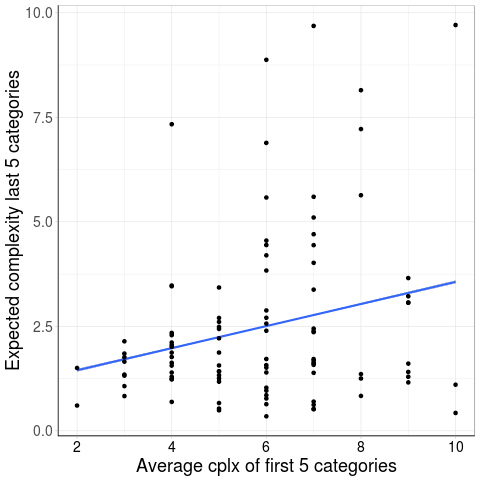

In [133]:
%%R

f_print <- function(args) {
    for (arg in args) {
        print(arg)
    }
}

p.1 <- ggplot(data=df, aes(x=step, y=alpha, group=chain,color=chain)) +
        stat_summary(fun.y="median", geom="line")


p.2 <- ggplot(data=df, aes(x=step, y=beta, group=chain,color=chain)) +
        stat_summary(fun.y="median", geom="line")

p.3 <- ggplot(data=df, aes(x=step, y=mean, group=chain,color=chain)) +
        stat_summary(fun.y="median", geom="line")


p.4 <- ggplot(data=df, aes(x=round(mdl), y=mean)) +
       # geom_jitter(alpha=0.2)+
        stat_smooth(method="lm") +
       stat_summary(fun.y="mean",geom="point",aes(group=subj)) +
       # stat_summary(fun.data="mean_cl_normal",geom="errorbar") +

        paper_theme +
        xlab("Average cplx of first 5 categories") +
        ylab("Expected complexity last 5 categories")
        
p.5 <- ggplot(data=df, aes(x=corr)) +
        stat_density(adjust=2)


#f_print(c(p.1))
#print(p.1)
#print(p.2)
#print(p.3)
print(p.4)
#print(p.5)
#f_print(p.4)
#print(p.1)

In [88]:
%%R

subjs <- rep(rep(seq.int(1,101),each=11), length(alphas)/length(subjs))

print(length(subjs))

print(length(alphas)/length(subjs))


[1] 1111
[1] 1222.364


In [111]:
%%R

f_gamma <- function(xs, alpha,beta,loc) {
    alpha <- alpha[1]
    beta <- beta[1]
    loc <- loc[1]

    ys <- (xs - loc) * beta
    
    pdf <- dgamma(ys,alpha)
    pdf <- pdf/sum(pdf)
    return(pdf)
}


x1 <- seq.int(0,8,1)

xs <- rep(x1,nrow(df))
rows <- rep(seq.int(1,nrow(df)), each=length(x1))
alphas <- rep(df$alpha,each=length(x1))
betas <- rep(df$beta,each=length(x1))
locs <- rep(df$loc, each =length(x1))
mdl_x <- rep(df$mdl, each =length(x1))

subjs <- rep(seq.int(1,length(unique(df$subj))),each=length(x1))
subjs <- rep(subjs, length(alphas)/length(subjs))


df_gamma <- data.frame(xs = xs, rows = rows,alpha=alphas,beta=betas,loc=locs, subjs=subjs,mdl=mdl_x)

df_gamma <- df_gamma %>%
            group_by(rows) %>%
            mutate(pdf = f_gamma(xs, alpha,beta,loc))
#df_gamma <- df_gamma %>%

df_gamma$id <- seq.int(1,nrow(df_gamma))
df_gamma_subj <- df_gamma %>%
            group_by(subjs,xs) %>%
            mutate(pdf=mean(pdf)) %>%
            top_n(n=1,wt=id)
head(df_gamma,30)


# A tibble: 30 x 9
# Groups:   rows [4]
      xs  rows alpha  beta     loc subjs   mdl    pdf    id
   <dbl> <int> <dbl> <dbl>   <dbl> <int> <dbl>  <dbl> <int>
 1    0.     1  2.10 0.602 -1.07       1  8.00 0.197      1
 2    1.     1  2.10 0.602 -1.07       1  8.00 0.223      2
 3    2.     1  2.10 0.602 -1.07       1  8.00 0.189      3
 4    3.     1  2.10 0.602 -1.07       1  8.00 0.141      4
 5    4.     1  2.10 0.602 -1.07       1  8.00 0.0984     5
 6    5.     1  2.10 0.602 -1.07       1  8.00 0.0658     6
 7    6.     1  2.10 0.602 -1.07       1  8.00 0.0426     7
 8    7.     1  2.10 0.602 -1.07       1  8.00 0.0270     8
 9    8.     1  2.10 0.602 -1.07       1  8.00 0.0168     9
10    0.     2  2.00 1.57   0.0169     2  4.80 0.        10
# ... with 20 more rows


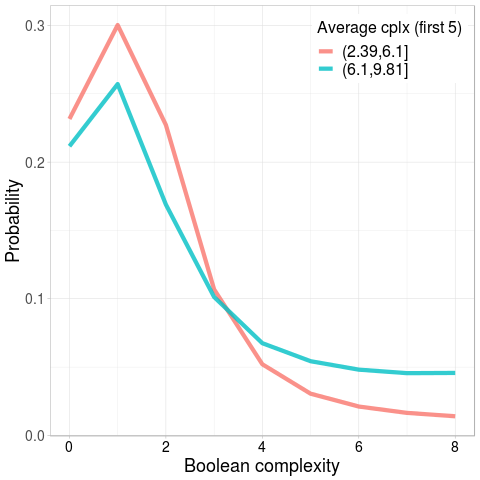

In [131]:
%%R


p.1 <-  ggplot(data=df_gamma_subj, aes(x=xs, y=pdf, group=subjs)) +
        geom_line()

df_gamma_argmax <- df_gamma_subj %>%
                    group_by(subjs) %>%
                    top_n(n=1,wt=pdf)


p.2 <- ggplot(data=df_gamma_argmax, aes(x=xs)) +
        geom_histogram(binwidth=1) +
        facet_wrap(~cut(mdl,2),nrow=3) +
        paper_theme

p.3 <- ggplot(data=df_gamma_subj, aes(x=xs, y=pdf,color=cut(mdl,2))) +
        stat_summary(fun.y="mean",geom="line", alpha=0.8,size=2.0) +
                    # , linetype="dashed") +
        paper_theme + xlab("Boolean complexity") + ylab("Probability") +
        guides(color=guide_legend(title="Average cplx (first 5)"))  +
        theme(legend.title=element_text(size=16), 
              legend.text=element_text(size=16), legend.position=c(0.8,0.9)) 


p.4 <- ggplot(data=data, aes(x=))


#print(p.2)

#print(p.3)



[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1575262982172989

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.15971456107648835

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.16095522518546693

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.15949291766988744

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1587370136375889

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.16055048078165304

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.16213761092696746

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1633349724090902

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1642431086735302

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18420546099838533

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18454614715168535

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18493164223467945

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18530361671649792

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18566331473306785

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18600313039552707

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18637362070652835

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18673539359844724

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18694046716497792

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19266139965397006

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1928169361286209

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19302952788867953

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.193100272771387

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1931277209469845

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19312509040918566

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19306176978848738

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19305880776271467

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1930950526855134

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.20238828638856046

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.20235205739896975

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.20218610877798315

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.20197907066345716

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.20179463598858097

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.20163934559180768

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.201467241881207

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.20129654309885606

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.20117416860459547

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1876557218095759

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1874456789961782

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18723671929700997

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18703370981236614

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18685718846609387

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1866919229489166

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18651753183114206

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18633025031000022

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18612312397455236

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0,

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18036021986262715

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18040166389251286

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1804429017331952

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18050739865533322

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1805715762857775

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1806540280799073

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18078696325068852

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1809192451773873

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1810508786632689

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1850253564269328

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18499738928677162

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1849695384340955

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18492286234752575

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18490547109445055

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18490520009409203

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18490493021126075

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18493271717180315

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18496039001751782

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1898175091004221

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18985176493552233

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.189885899080267

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18991991218194518

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18992981980921164

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18993969242719444

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18995448105470056

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.18996921760957458

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1899839023663647

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19213211230102825

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19214606800195855

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19216867740171817

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19219121669481187

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19220467235130054

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1922197873188345

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19223485563523407

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19225997295587136

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19228501299244521

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19453654003194

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19451915637363915

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19450182073649386

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19448453292179582

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.194463549139953

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19444187195278262

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19442240827093127

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19439825871692964

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19437278346837322

[0.2, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0

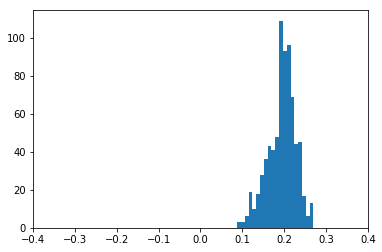

In [91]:
#alpha_mean = np.median(np.median(all_alphas[:2], axis=1),axis=0)


a_flat = np.concatenate(all_alphas)
b_flat = np.concatenate(all_betas)
n_flat = np.concatenate(all_noises)
l_flat = np.concatenate(all_locs)
post_flat = np.concatenate(all_posts)


means = np.zeros(len(a_flat[0]))
corrs = []
preds = []

for i in range(len(a_flat)):
    a_s = a_flat[i]
    b_s = b_flat[i]
    n_s = n_flat[i]
    l_s = l_flat[i]
    mean_i = []
    
    for j in range(len(a_s)):
        a = a_s[j]
        b = b_s[j]
        n = n_s[j]
        l = l_s[j]
        
        xs = np.arange(0,17,1)
        pred = st.gamma.pdf(xs, a=a, loc=l, scale=1./b)

        pred = pred/np.sum(pred)
        
        preds.append(pred)
        pred_mean = np.sum(pred*xs)
        mean_i.append(pred_mean)
        
        means[j] += pred_mean
        
    corrs.append(st.pearsonr(mean_i, mdls)[0])
    print([round(x,1) for x in np.mean(preds,axis=0)])
    print(np.mean(corrs))
    print("")
            
        
means = means/len(a_flat)
        

#print(means)
#print(np.mean(a_flat,axis=

    
#print(alpha_mean.shape)
mean_corr = st.pearsonr(means, mdls)
print(mean_corr)

plt.hist(corrs,bins=20)
plt.xlim((-0.4,0.4))


corrs = sorted(corrs)
print(corrs[int(len(corrs)/40)],corrs[int(len(corrs)/2)], corrs[int(39*len(corrs)/40)])


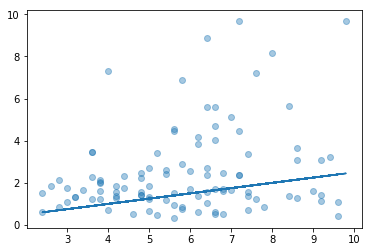

In [92]:
plt.scatter(mdls, means, alpha=0.4)
plt.plot(mdls, mdls * mean_corr[0])
#plt.scatter(mdls, np.mean(n_flat,axis=0))

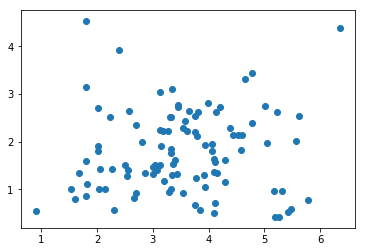

In [93]:

post_flat_exp = post_flat - np.min(post_flat)
post_flat_exp = post_flat_exp/np.sum(post_flat_exp)

post_a = np.sum(post_flat_exp.reshape(len(post_flat),1) * a_flat,axis=0)
post_b = np.sum(post_flat_exp.reshape(len(post_flat),1) * b_flat,axis=0)

#df = pd.DataFrame(mdls=mdls,pmean=post_a/post_b)

plt.scatter(post_a,post_b)
#sns.lmplot(x="mdls", y="pmean")

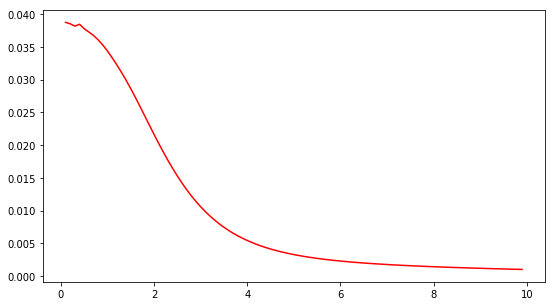

In [94]:
#plt.scatter(means,mdls)

#a_mean = a_flat.mean(axis=0)
#b_mean = b_flat.mean(axis=0)

a_mean = np.mean(a_flat, axis=0)
b_mean = np.mean(b_flat,axis=0)
l_mean = np.mean(l_flat,axis=0)



xs = np.arange(0.1,10,0.1)

curves = []
plt.figure(figsize=(9,5))
for i in range(len(a_mean)):
    curve = st.gamma.pdf(xs, a=a_mean[i],loc=l_mean[i],scale=1./b_mean[i])
    curve = curve/np.sum(curve)
    curves.append(curve)

    #plt.plot(xs,
        #     np.log2(curve), 'b', alpha=0.15)
    #plt.xlabel("Boolean complexity")
   # plt.ylabel("Probability density")


#xs = np.arange(0,17,1)
#plt.plot(np.log2(xs), np.log2(xs), 'r',markersize=5)

plt.plot(xs, np.mean(curves,axis=0), 'r',markersize=5)
plt.show()


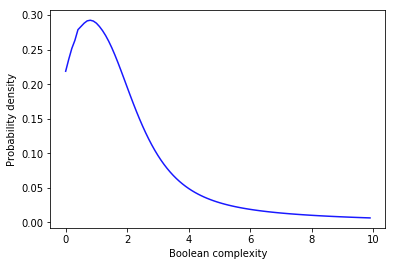

In [95]:
xs = np.arange(0.0,10.0,0.1)

mean_curve = np.zeros(len(xs))
for i in range(len(a_mean)):
    curve = st.gamma.pdf(xs*1.0, a=a_mean[i],loc=l_mean[i],scale=1./b_mean[i])
    
    mean_curve += curve/len(a_mean)
    
    
plt.plot(xs,
         mean_curve, 'b', alpha=0.9)
plt.xlabel("Boolean complexity")
plt.ylabel("Probability density")

plt.show()

In [17]:
alphas = np.arange(0.5,10,0.25)
betas = np.arange(0.5,10,0.25)
noises = np.arange(0.1,0.5,0.05)


best_post = float("-inf")
best_tup =None

for alpha in alphas:
    for beta in betas:
        for noise in noises:
            post = compute_posterior(cplxs,mod_preds,hum_preds,dists,seen, alpha,beta,noise)
            
            #print(round(alpha,2),round(beta,2),round(noise,2),round(post))
            
            if post > best_post:
                best_tup = (round(alpha,2)
                all_posts = np.array(all_posts),round(beta,2),round(noise,2))
                best_post = post
                
                print(best_post, best_tup)
                

SyntaxError: invalid syntax (<ipython-input-17-c350513d2fb3>, line 18)